# 06 — Model Training (Hopsworks Feature Store)

This notebook trains forecasting models using the **engineered traffic features** plus **weather** and **TfL disruption** features stored in Hopsworks Feature Groups.

**Targets / labels** come from a separate Label Feature Group (generated in your label backfill notebook):
- `label_speed_ratio_t_plus_30`
- `label_speed_ratio_t_plus_60`

The notebook:
1. Logs into Hopsworks
2. Reads Feature Groups into pandas
3. Builds a training dataframe by joining on `(point_id, time)`
4. Trains one model per horizon (30m, 60m)
5. Saves artifacts (`.joblib` + JSON metadata)

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import hopsworks



import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

C:\Users\omarl\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------
# Hopsworks connection
# -------------------------
HOPSWORKS_HOST = os.getenv("HOPSWORKS_HOST", "")  # e.g. "eu-west.cloud.hopsworks.ai"
HOPSWORKS_PROJECT = os.getenv("HOPSWORKS_PROJECT", "")  # e.g. "London_traffic"
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY", "")  # recommended for non-interactive runs

# -------------------------
# Feature Group names/versions (defaults from your existing notebooks)
# -------------------------
# Feature View
FV_NAME = os.getenv("FV_NAME", "traffic_speed_ratio_fv")
FV_VERSION = int(os.getenv("FV_VERSION", "1"))

# Column names (adjust if your FV uses different names/prefixes)
POINT_ID_COL = os.getenv("POINT_ID_COL", "point_id")
TIME_COL = os.getenv("TIME_COL", "ts_10m")
LABEL_30_COL = os.getenv("LABEL_30_COL", "label_speed_ratio_t_plus_30")
LABEL_60_COL = os.getenv("LABEL_60_COL", "label_speed_ratio_t_plus_60")

# Optional batch window (if your HSFS requires it)
# Formats accepted by HSFS: YYYYMMDD, YYYYMMDDHH, YYYYMMDDHHMM, YYYYMMDDHHMMSS
BATCH_START_TIME = os.getenv("BATCH_START_TIME", "")  # e.g. "20260101000000"
BATCH_END_TIME = os.getenv("BATCH_END_TIME", "")      # e.g. "20260111235959"

ARTIFACT_DIR = Path(os.getenv("ARTIFACT_DIR", "artifacts"))
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("Config:")
print("Host:", HOPSWORKS_HOST)
print("Project:", HOPSWORKS_PROJECT)
print("FV:", FV_NAME, FV_VERSION)
print("Cols:", POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL)
print("Batch window:", BATCH_START_TIME, "->", BATCH_END_TIME)

Config:
Host: 
Project: 
FV: traffic_speed_ratio_fv 1
Cols: point_id ts_10m label_speed_ratio_t_plus_30 label_speed_ratio_t_plus_60
Batch window:  -> 


In [3]:
project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
    project="London_traffic")
fs = project.get_feature_store()

print("Connected to feature store:", fs.name)


2026-01-11 11:39:50,724 INFO: Initializing external client
2026-01-11 11:39:50,725 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-11 11:39:51,956 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3209
Connected to feature store: london_traffic_featurestore


In [4]:
feature_view = fs.get_feature_view(name=FV_NAME, version=FV_VERSION)
if feature_view is None:
    raise RuntimeError(f"Feature View not found: {FV_NAME} v{FV_VERSION}. Check Hopsworks UI.")
print("Using Feature View:", feature_view.name, feature_view.version)

Using Feature View: traffic_speed_ratio_fv 1


In [6]:
feature_df, label_df = feature_view.training_data(
    description="traffic_speed_ratio_fv full training dataframe"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.50s) 
2026-01-11 11:41:47,525 INFO: Computing insert statistics


In [7]:
df = pd.concat([feature_df.reset_index(drop=True), label_df.reset_index(drop=True)], axis=1)

print("df:", df.shape)

# Detect label cols automatically
LABEL_30_COL = next((c for c in df.columns if c.endswith("t_plus_30") and "label_speed_ratio" in c), None)
LABEL_60_COL = next((c for c in df.columns if c.endswith("t_plus_60") and "label_speed_ratio" in c), None)

print("Detected:", LABEL_30_COL, LABEL_60_COL)

if LABEL_30_COL is None or LABEL_60_COL is None:
    raise ValueError("Labels not found in df. Check label_df columns printed above.")

df: (26157, 50)
Detected: labels_speed_ratio_fg_label_speed_ratio_t_plus_30 labels_speed_ratio_fg_label_speed_ratio_t_plus_60


In [8]:
df = df.rename(columns={
    LABEL_30_COL: "label_speed_ratio_t_plus_30",
    LABEL_60_COL: "label_speed_ratio_t_plus_60",
})
LABEL_30_COL = "label_speed_ratio_t_plus_30"
LABEL_60_COL = "label_speed_ratio_t_plus_60"

print("Labels renamed to:", LABEL_30_COL, LABEL_60_COL)

Labels renamed to: label_speed_ratio_t_plus_30 label_speed_ratio_t_plus_60


In [9]:
def resolve_col(df: pd.DataFrame, base: str) -> str:
    """Resolve column name if the Feature View adds prefixes."""
    if base in df.columns:
        return base
    cands = [c for c in df.columns if c.endswith(base)]
    if len(cands) == 1:
        return cands[0]
    cands = [c for c in df.columns if c.endswith(f".{base}")]
    if len(cands) == 1:
        return cands[0]
    raise KeyError(f"Could not resolve '{base}'. Example cols: {list(df.columns)[:40]}")

In [10]:
# -------------------------
# Normalize required column names
# -------------------------
POINT_ID_COL = resolve_col(df, POINT_ID_COL)
TIME_COL = resolve_col(df, TIME_COL)
LABEL_30_COL = resolve_col(df, LABEL_30_COL)
LABEL_60_COL = resolve_col(df, LABEL_60_COL)

print("Resolved columns:")
print(" point_id:", POINT_ID_COL)
print(" time:", TIME_COL)
print(" label_30:", LABEL_30_COL)
print(" label_60:", LABEL_60_COL)

df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
df[POINT_ID_COL] = df[POINT_ID_COL].astype(str)

df = df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")
df = df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

print("After basic cleaning:", df.shape)
df[[POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL]].head()


Resolved columns:
 point_id: point_id
 time: ts_10m
 label_30: label_speed_ratio_t_plus_30
 label_60: label_speed_ratio_t_plus_60
After basic cleaning: (26157, 50)


,point_id,ts_10m,label_speed_ratio_t_plus_30,label_speed_ratio_t_plus_60
0,16108,2026-01-10 14:40:00+00:00,NaN,NaN
1,16108,2026-01-11 13:10:00+00:00,NaN,NaN
2,16228,2026-01-11 16:00:00+00:00,NaN,NaN
3,16250,2026-01-11 16:00:00+00:00,NaN,NaN
4,16435,2026-01-04 21:00:00+00:00,0.941176,0.944444


In [11]:
df.columns

Index(['timestamp_utc', 'point_id', 'frc', 'current_speed', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'road_closure', 'ts_10m', 'speed_ratio', 'delay_seconds',
       'day_of_week', 'is_weekend', 'hour', 'minute', 'is_rush_hour', 'ti_evening_peak', 'ti_midday', 'ti_morning_peak', 'ti_night', 'speed_diff', 'travel_time_ratio', 'low_confidence_flag',
       'speed_roll_mean_3', 'speed_roll_std_3', 'delay_roll_mean_3', 'speed_roll_mean_6', 'speed_roll_std_6', 'delay_roll_mean_6', 'speed_roll_mean_12', 'speed_roll_std_12', 'delay_roll_mean_12',
       'labels_speed_ratio_fg_point_id', 'labels_speed_ratio_fg_ts_10m', 'weather_10m_fg_point_id', 'weather_10m_fg_ts_10m', 'weather_10m_fg_precipitation', 'weather_10m_fg_rain',
       'weather_10m_fg_snowfall', 'weather_10m_fg_temperature_2m', 'tfl_disruptions_10m_fg_point_id', 'tfl_disruptions_10m_fg_ts_10m', 'tfl_disruptions_10m_fg_disruption_count',
       'tfl_disruptions_10m_fg_is_active', 'tfl_disrupti

In [12]:
# -------------------------
# NA handling
# - Weather: forward fill per point, then median
# - TfL (hourly): forward fill per point, remaining initial NaNs -> 0
# -------------------------
possible_weather_cols = [
    'weather_10m_fg_precipitation', 'weather_10m_fg_rain',
       'weather_10m_fg_snowfall', 'weather_10m_fg_temperature_2m'
]
possible_tfl_cols = ['tfl_disruptions_10m_fg_point_id', 'tfl_disruptions_10m_fg_ts_10m', 'tfl_disruptions_10m_fg_disruption_count',
       'tfl_disruptions_10m_fg_is_active', 'tfl_disruptions_10m_fg_is_incident', 'tfl_disruptions_10m_fg_is_works', 'tfl_disruptions_10m_fg_max_ordinal']

def find_cols_by_suffix(possible, columns):
    found = []
    for base in possible:
        if base in columns:
            found.append(base)
            continue
        cands = [c for c in columns if c.endswith(base)]
        if len(cands) == 1:
            found.append(cands[0])
    return found

weather_cols = find_cols_by_suffix(possible_weather_cols, df.columns.tolist())
tfl_cols = find_cols_by_suffix(possible_tfl_cols, df.columns.tolist())

print("Weather cols detected:", weather_cols)
print("TfL cols detected:", tfl_cols)

# Ensure correct ordering for fills
df = df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

# Weather fills
for c in weather_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill().bfill()
    med = float(df[c].median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med)

# TfL fills: hourly -> carry last hour forward
for c in tfl_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill()
    df[c] = df[c].fillna(0.0)

# Labels sanity
df[LABEL_30_COL] = pd.to_numeric(df[LABEL_30_COL], errors="coerce")
df[LABEL_60_COL] = pd.to_numeric(df[LABEL_60_COL], errors="coerce")
df = df.dropna(subset=[LABEL_30_COL, LABEL_60_COL]).reset_index(drop=True)

print("After NA handling:", df.shape)


Weather cols detected: ['weather_10m_fg_precipitation', 'weather_10m_fg_rain', 'weather_10m_fg_snowfall', 'weather_10m_fg_temperature_2m']
TfL cols detected: ['tfl_disruptions_10m_fg_point_id', 'tfl_disruptions_10m_fg_ts_10m', 'tfl_disruptions_10m_fg_disruption_count', 'tfl_disruptions_10m_fg_is_active', 'tfl_disruptions_10m_fg_is_incident', 'tfl_disruptions_10m_fg_is_works', 'tfl_disruptions_10m_fg_max_ordinal']
After NA handling: (25718, 50)


In [14]:
df.columns

Index(['timestamp_utc', 'point_id', 'frc', 'current_speed', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'road_closure', 'ts_10m', 'speed_ratio', 'delay_seconds',
       'day_of_week', 'is_weekend', 'hour', 'minute', 'is_rush_hour', 'ti_evening_peak', 'ti_midday', 'ti_morning_peak', 'ti_night', 'speed_diff', 'travel_time_ratio', 'low_confidence_flag',
       'speed_roll_mean_3', 'speed_roll_std_3', 'delay_roll_mean_3', 'speed_roll_mean_6', 'speed_roll_std_6', 'delay_roll_mean_6', 'speed_roll_mean_12', 'speed_roll_std_12', 'delay_roll_mean_12',
       'labels_speed_ratio_fg_point_id', 'labels_speed_ratio_fg_ts_10m', 'weather_10m_fg_point_id', 'weather_10m_fg_ts_10m', 'weather_10m_fg_precipitation', 'weather_10m_fg_rain',
       'weather_10m_fg_snowfall', 'weather_10m_fg_temperature_2m', 'tfl_disruptions_10m_fg_point_id', 'tfl_disruptions_10m_fg_ts_10m', 'tfl_disruptions_10m_fg_disruption_count',
       'tfl_disruptions_10m_fg_is_active', 'tfl_disrupti

In [16]:
# -------------------------
# Train/Val/Test split (time-based)
# -------------------------
TEST_FRACTION = float(os.getenv("TEST_FRACTION", "0.2"))
VAL_FRACTION = float(os.getenv("VAL_FRACTION", "0.1"))

df_sorted = df.sort_values(TIME_COL).reset_index(drop=True)

n = len(df_sorted)
cut_test = int(round(n * (1 - TEST_FRACTION)))
train_full = df_sorted.iloc[:cut_test].copy()
test_df = df_sorted.iloc[cut_test:].copy()

n_tr = len(train_full)
cut_val = int(round(n_tr * (1 - VAL_FRACTION)))
train_df = train_full.iloc[:cut_val].copy()
val_df = train_full.iloc[cut_val:].copy()

print("Rows:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})

# Features: everything except time + labels
exclude = {TIME_COL, LABEL_30_COL, LABEL_60_COL, 'tfl_disruptions_10m_fg_point_id', 'tfl_disruptions_10m_fg_ts_10m'}
feature_cols = [c for c in df.columns if c not in exclude]

# Keep only numeric columns for the NN input
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

X_train = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_val   = val_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_test  = test_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()

y_train = train_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_val   = val_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_test  = test_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()

print("Shapes:")
print(" X_train:", X_train.shape, "y_train:", y_train.shape)
print(" X_val  :", X_val.shape, "y_val  :", y_val.shape)
print(" X_test :", X_test.shape, "y_test :", y_test.shape)


Rows: {'train': 18517, 'val': 2057, 'test': 5144}
Shapes:
 X_train: (18517, 39) y_train: (18517, 2)
 X_val  : (2057, 39) y_val  : (2057, 2)
 X_test : (5144, 39) y_test : (5144, 2)


In [17]:
# -------------------------
# Scale features (fit on train only)
# -------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)

print("Dtypes:", X_train.dtype, y_train.dtype)
print("Finite X:", np.isfinite(X_train).all(), "Finite y:", np.isfinite(y_train).all())


Dtypes: float32 float32
Finite X: True Finite y: True


In [18]:
# -------------------------
# Keras model (your current best Sequential baseline)
# -------------------------
tf.keras.utils.set_random_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),   # remove this if it hurts performance
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, activation="linear"),  # assumes labels are in [0,1]
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="mse",
    metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
             keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,050 (211.13 KB)

 Trainable params: 53,794 (210.13 KB)

 Non-trainable params: 256 (1.00 KB)

In [19]:
# -------------------------
# Train (EarlyStopping + ReduceLROnPlateau)
# NOTE: If you switch to a LearningRateSchedule, remove ReduceLROnPlateau.
# -------------------------
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print("Best val_loss:", float(np.min(history.history["val_loss"])))


Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9098 - mae: 0.7252 - rmse: 0.9538 - val_loss: 0.4925 - val_mae: 0.6799 - val_rmse: 0.7018 - learning_rate: 3.0000e-04
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3834 - mae: 0.4780 - rmse: 0.6192 - val_loss: 0.3713 - val_mae: 0.5872 - val_rmse: 0.6093 - learning_rate: 3.0000e-04
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2591 - mae: 0.3981 - rmse: 0.5090 - val_loss: 0.2381 - val_mae: 0.4641 - val_rmse: 0.4879 - learning_rate: 3.0000e-04
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1991 - mae: 0.3505 - rmse: 0.4462 - val_loss: 0.1562 - val_mae: 0.3676 - val_rmse: 0.3952 - learning_rate: 3.0000e-04
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1653 - mae: 0.3205 - rmse: 0.4066 - val_loss: 0.1037 - val_mae: 0.2931 - val_rmse: 0.3221 - learning_rate: 3.0000e-04
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1400 - mae: 0.2937 - rmse: 0.3742 - val_loss

In [20]:
# -------------------------
# Evaluate on TEST
# -------------------------
pred = model.predict(X_test, verbose=0)

def eval_metrics(y_true, y_pred):
    mse = float(mean_squared_error(y_true, y_pred))
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_true, y_pred))
    return {"mse": mse, "mae": mae, "rmse": rmse, "r2": r2}

m30 = eval_metrics(y_test[:, 0], pred[:, 0])
m60 = eval_metrics(y_test[:, 1], pred[:, 1])

print("Evaluation on TEST set:")
print(" t+30:", m30)
print(" t+60:", m60)


Evaluation on TEST set:
 t+30: {'mse': 0.015769924968481064, 'mae': 0.09861893951892853, 'rmse': 0.12557836186414068, 'r2': 0.5187692977768645}
 t+60: {'mse': 0.01690705120563507, 'mae': 0.1021706834435463, 'rmse': 0.13002711719343418, 'r2': 0.46072447285119666}


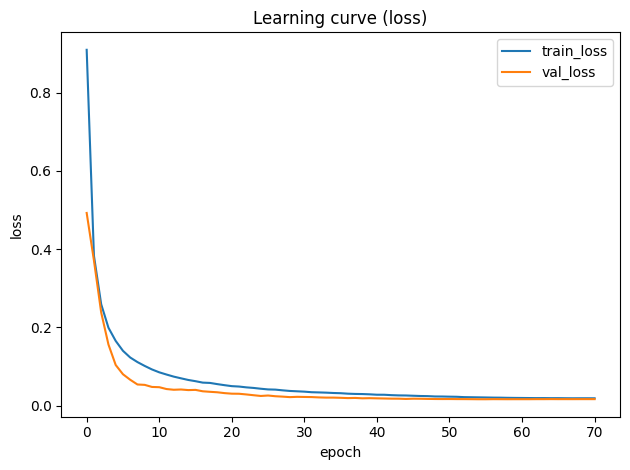

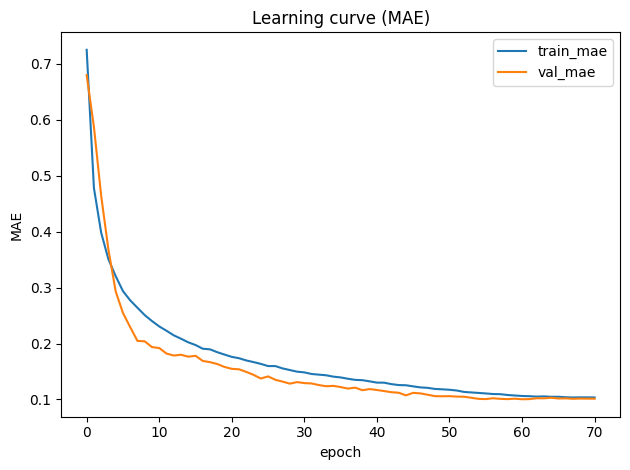

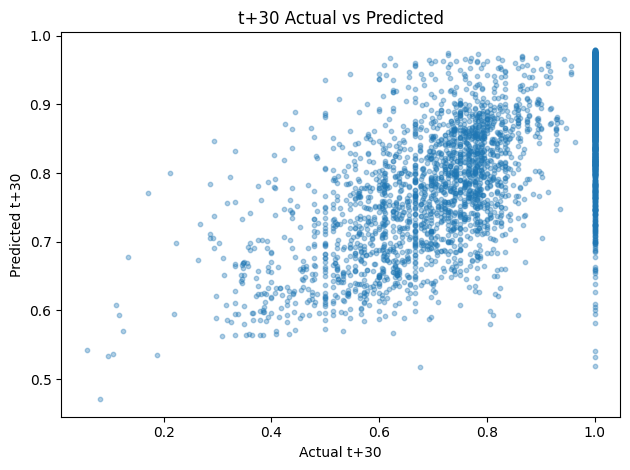

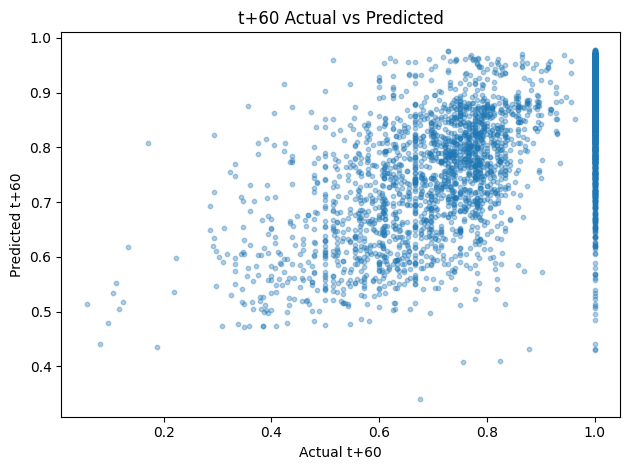

In [22]:
# -------------------------
# Plots: learning curves + scatters
# -------------------------
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Learning curve (loss)")
plt.legend()
plt.tight_layout()
plt.show()

if "mae" in history.history and "val_mae" in history.history:
    plt.figure()
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.xlabel("epoch")
    plt.ylabel("MAE")
    plt.title("Learning curve (MAE)")
    plt.legend()
    plt.tight_layout()
    plt.show()

for j, name in [(0, "t+30"), (1, "t+60")]:
    plt.figure()
    plt.scatter(y_test[:, j], pred[:, j], s=10, alpha=0.35)
    plt.xlabel(f"Actual {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name} Actual vs Predicted")
    plt.tight_layout()
    plt.show()


In [23]:
def to_float(x):
    return float(x)

# m30 and m60 are dicts like {'mse':..., 'mae':..., 'rmse':..., 'r2':...}
metrics_flat = {
    "test_mse_t30": to_float(m30["mse"]),
    "test_mae_t30": to_float(m30["mae"]),
    "test_rmse_t30": to_float(m30["rmse"]),
    "test_r2_t30": to_float(m30["r2"]),
    "test_mse_t60": to_float(m60["mse"]),
    "test_mae_t60": to_float(m60["mae"]),
    "test_rmse_t60": to_float(m60["rmse"]),
    "test_r2_t60": to_float(m60["r2"]),
}

# OPTIONAL: keep the nested structure too (for your own use)
metrics_nested = {
    "t_plus_30": {k: to_float(v) for k, v in m30.items()},
    "t_plus_60": {k: to_float(v) for k, v in m60.items()},
}

print("metrics_flat:", metrics_flat)
print("metrics_nested:", metrics_nested)

metrics_flat: {'test_mse_t30': 0.015769924968481064, 'test_mae_t30': 0.09861893951892853, 'test_rmse_t30': 0.12557836186414068, 'test_r2_t30': 0.5187692977768645, 'test_mse_t60': 0.01690705120563507, 'test_mae_t60': 0.1021706834435463, 'test_rmse_t60': 0.13002711719343418, 'test_r2_t60': 0.46072447285119666}
metrics_nested: {'t_plus_30': {'mse': 0.015769924968481064, 'mae': 0.09861893951892853, 'rmse': 0.12557836186414068, 'r2': 0.5187692977768645}, 't_plus_60': {'mse': 0.01690705120563507, 'mae': 0.1021706834435463, 'rmse': 0.13002711719343418, 'r2': 0.46072447285119666}}


In [24]:
MODEL_DIR = Path("artifacts/model_package")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---- 1) Save Keras model ----
# Recommended in TF/Keras 3: save as .keras
keras_path = MODEL_DIR / "model.keras"
model.save(keras_path)

# ---- 2) Save scaler (sklearn) ----
# assumes you have `scaler` already fit
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")

# ---- 3) Save feature column order ----
# assumes you have `feature_cols` (list) that defines X order BEFORE scaling
with open(MODEL_DIR / "feature_cols.json", "w") as f:
    json.dump(feature_cols, f, indent=2)

# ---- 4) Save metadata ----
meta = {
    "time_col": TIME_COL,
    "point_id_col": POINT_ID_COL,
    "label_30_col": LABEL_30_COL,
    "label_60_col": LABEL_60_COL,
    "n_features": int(len(feature_cols)),
}
with open(MODEL_DIR / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# ---- 5) Save metrics ----
# assumes you computed metrics dict like:
# metrics = {"t+30": {...}, "t+60": {...}}
with open(MODEL_DIR / "metrics.json", "w") as f:
    json.dump(metrics_flat, f, indent=2)

print("Saved model package to:", MODEL_DIR.resolve())
print("Files:", [p.name for p in MODEL_DIR.iterdir()])

Saved model package to: C:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-for-London-Final-Project\notebooks\artifacts\model_package
Files: ['feature_cols.json', 'meta.json', 'metrics.json', 'model.keras', 'scaler.pkl']


In [25]:
MODEL_NAME = "traffic_speed_ratio_keras"
MODEL_VERSION = 2

mr = project.get_model_registry()

# Create a model entry in the registry
# Use python model for generic artifact folders (keras + scaler + jsons)
try:
    model_registry_entry = mr.python.create_model(
        name=MODEL_NAME,
        version=MODEL_VERSION,
        description="Keras MLP model for London traffic speed_ratio forecasting (t+30, t+60). Includes scaler + feature columns.",
        metrics=metrics_flat,  # dict
    )
except Exception as e:
    # If it already exists, retrieve it
    print("Create failed (maybe exists). Trying get_model:", str(e))
    model_registry_entry = mr.get_model(MODEL_NAME, MODEL_VERSION)

# Upload the folder
model_registry_entry.save(str(MODEL_DIR))

print(f"✅ Uploaded model to Hopsworks Model Registry: {MODEL_NAME} v{MODEL_VERSION}")

Uploading c:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-for-London-Final-Project\notebooks\artifacts\model_package/feature_cols.json: 100.000%|██████████| 956/956 elapsed<00:02 remaining<00:00
Uploading c:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-for-London-Final-Project\notebooks\artifacts\model_package/meta.json: 100.000%|██████████| 180/180 elapsed<00:03 remaining<00:00
Uploading c:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-for-London-Final-Project\notebooks\artifacts\model_package/metrics.json: 100.000%|██████████| 322/322 elapsed<00:02 remaining<00:00
Uploading c:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-for-London-Final-Project\notebooks\artifacts\model_package/model.keras: 100.000%|██████████| 697206/697206 elapsed<00:03 remaining<00:00
Uploading c:\Users\omarl\OneDrive\Documentos\GitHub\Short-term-traffic-congestion-prediction-

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/3209/models/traffic_speed_ratio_keras/2
✅ Uploaded model to Hopsworks Model Registry: traffic_speed_ratio_keras v2
